<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.04/Twitter_analysis_by_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (91.3 kB/s)
Reading package li

In [74]:
# Download a Postgres driver that will allow Spark to interact with Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-09-01 23:37:20--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.2’

postgresql-42.2.16. 100%[===================>] 979.38K  4.59MB/s    in 0.2s    

2022-09-01 23:37:21 (4.59 MB/s) - ‘postgresql-42.2.16.jar.2’ saved [1002883/1002883]



In [75]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [76]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://aiscience22.s3.us-west-1.amazonaws.com/joined.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("joined.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|extractedts|is_retweet|is_quote_status|weekofyear|        cleaned_text|   negative|    neutral|   positive|search_results|    weight|
+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     Theo1001|      312|      123|      38156|   2008-05-14|    2022-04-22|          67|[{''text'': ''Sta...|      en|             0| 2022-04-22|      true|          false|        16|thank you si

In [77]:
# Convert DataFrame to Pandas
tweets_df = text_df.toPandas()
print(tweets_df.shape)
tweets_df.head(5)

(451700, 20)


,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449,196000.0,0.000985
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744,94500.0,0.000475
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457,94500.0,0.000475
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,2022-04-24,True,False,16,thank you,0.169791,0.608387,0.221821,94500.0,0.000475
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928,196000.0,0.000985


In [78]:
# Drop null values
tweets_df=tweets_df.dropna()
print(tweets_df.shape)

(83147, 20)


In [79]:
# Check data types
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83147 entries, 0 to 83161
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   username         83147 non-null  object 
 1   following        83147 non-null  int32  
 2   followers        83147 non-null  int32  
 3   totaltweets      83147 non-null  int32  
 4   usercreatedts    83147 non-null  object 
 5   tweetcreatedts   83147 non-null  object 
 6   retweetcount     83147 non-null  int32  
 7   hashtags         83147 non-null  object 
 8   language         83147 non-null  object 
 9   favorite_count   83147 non-null  int32  
 10  extractedts      83147 non-null  object 
 11  is_retweet       83147 non-null  bool   
 12  is_quote_status  83147 non-null  bool   
 13  weekofyear       83147 non-null  int32  
 14  cleaned_text     83147 non-null  object 
 15  negative         83147 non-null  float64
 16  neutral          83147 non-null  float64
 17  positive    

In [80]:
# Change the dtypes of usercreatedts, tweetcreatedts, and extractedts to datetime64 for easier operation later
tweets_df["usercreatedts"] = pd.to_datetime(tweets_df["usercreatedts"])
tweets_df["tweetcreatedts"] = pd.to_datetime(tweets_df["tweetcreatedts"])
tweets_df["extractedts"] = pd.to_datetime(tweets_df["extractedts"])

# check dtypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83147 entries, 0 to 83161
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   username         83147 non-null  object        
 1   following        83147 non-null  int32         
 2   followers        83147 non-null  int32         
 3   totaltweets      83147 non-null  int32         
 4   usercreatedts    83147 non-null  datetime64[ns]
 5   tweetcreatedts   83147 non-null  datetime64[ns]
 6   retweetcount     83147 non-null  int32         
 7   hashtags         83147 non-null  object        
 8   language         83147 non-null  object        
 9   favorite_count   83147 non-null  int32         
 10  extractedts      83147 non-null  datetime64[ns]
 11  is_retweet       83147 non-null  bool          
 12  is_quote_status  83147 non-null  bool          
 13  weekofyear       83147 non-null  int32         
 14  cleaned_text     83147 non-null  objec

In [81]:
# When were the earliest and latest tweets in this dataset created
earliest_tweet = tweets_df["tweetcreatedts"].min()
latest_tweet = tweets_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-04-22 00:00:00, and the latest was at 2022-06-13 00:00:00


In [82]:
# get dates in the dataframe 
#dates = tweets_df["tweetcreatedts"].dt.day
dates = tweets_df["tweetcreatedts"].dt.date
dates


0        2022-04-22
1        2022-04-24
2        2022-04-24
3        2022-04-24
4        2022-04-22
            ...    
83157    2022-06-03
83158    2022-06-03
83159    2022-06-04
83160    2022-06-04
83161    2022-06-04
Name: tweetcreatedts, Length: 83147, dtype: object

In [83]:
# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = tweets_df["tweetcreatedts"].groupby(dates).size()
max = tweets_df["tweetcreatedts"].groupby(dates).size().max
tweetcount_by_date.head(50)


tweetcreatedts
2022-04-22    3229
2022-04-23    4743
2022-04-24    4802
2022-04-25    4149
2022-04-26    4784
2022-04-27    4325
2022-04-28    4187
2022-04-29    4358
2022-04-30    4856
2022-05-01    5119
2022-05-02    4838
2022-05-03    4545
2022-05-04    5987
2022-05-05    6295
2022-05-06     716
2022-05-07      10
2022-05-09    5908
2022-05-10      16
2022-05-11       4
2022-05-12       5
2022-05-13       1
2022-05-14      42
2022-06-01    3585
2022-06-02    3177
2022-06-03    2185
2022-06-04    1255
2022-06-06       2
2022-06-07       7
2022-06-08       3
2022-06-09       4
2022-06-10       7
2022-06-13       3
Name: tweetcreatedts, dtype: int64

In [84]:
tweetcount_by_date.tail(50)

tweetcreatedts
2022-04-22    3229
2022-04-23    4743
2022-04-24    4802
2022-04-25    4149
2022-04-26    4784
2022-04-27    4325
2022-04-28    4187
2022-04-29    4358
2022-04-30    4856
2022-05-01    5119
2022-05-02    4838
2022-05-03    4545
2022-05-04    5987
2022-05-05    6295
2022-05-06     716
2022-05-07      10
2022-05-09    5908
2022-05-10      16
2022-05-11       4
2022-05-12       5
2022-05-13       1
2022-05-14      42
2022-06-01    3585
2022-06-02    3177
2022-06-03    2185
2022-06-04    1255
2022-06-06       2
2022-06-07       7
2022-06-08       3
2022-06-09       4
2022-06-10       7
2022-06-13       3
Name: tweetcreatedts, dtype: int64

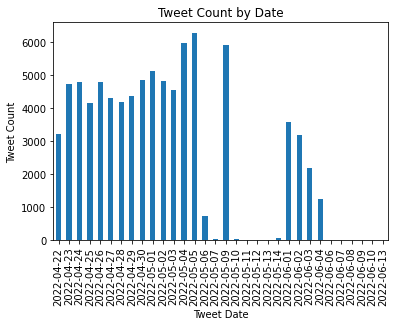

In [85]:
# Visualize tweet counts by date

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=90)
plt.show()

In [86]:
# Change the negative score to negative value
tweets_df["negative"] = -1.0*tweets_df["negative"]
tweets_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449,196000.0,0.000985
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,-0.004823,0.675433,0.319744,94500.0,0.000475
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457,94500.0,0.000475
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,2022-04-24,True,False,16,thank you,-0.169791,0.608387,0.221821,94500.0,0.000475
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,-0.156944,0.766128,0.076928,196000.0,0.000985


In [87]:
# Extract negative score of twits and time, when they were created
negative_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
negative_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
1,2022-04-24,-0.004823
2,2022-04-24,-0.018234
3,2022-04-24,-0.169791
4,2022-04-22,-0.156944


In [88]:
# get dates in the dataframe 
dates = negative_tweets_df["tweetcreatedts"].dt.date
dates

0        2022-04-22
1        2022-04-24
2        2022-04-24
3        2022-04-24
4        2022-04-22
            ...    
83157    2022-06-03
83158    2022-06-03
83159    2022-06-04
83160    2022-06-04
83161    2022-06-04
Name: tweetcreatedts, Length: 83147, dtype: object

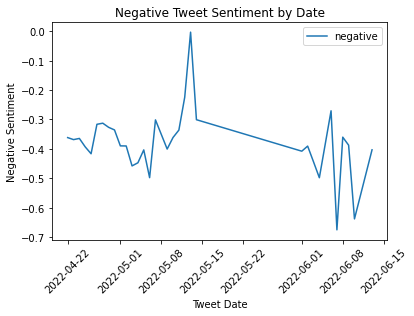

In [89]:
# Visualize negative tweet sentiment by date

# group tweet timestamps by date and get mean negative score for each date
negative_by_date =  negative_tweets_df.groupby([negative_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet negative sentiment by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiment by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [90]:
# Extract positive score of twits and time, when they were created
positive_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
positive_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
1,2022-04-24,-0.004823
2,2022-04-24,-0.018234
3,2022-04-24,-0.169791
4,2022-04-22,-0.156944


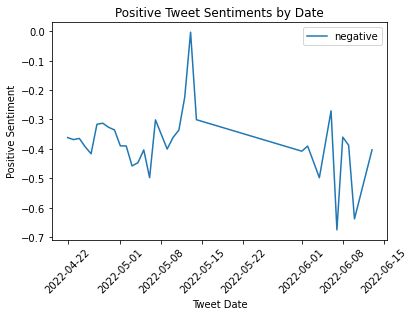

In [91]:
# Visualize positive tweet sentiment by date
# get dates in the dataframe 
dates = positive_tweets_df["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean positive score for each date
positive_by_date =  positive_tweets_df.groupby([positive_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_by_date.plot.line();

plt.title("Positive Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

# Analysis for Ukraine - Russia comparison


In [92]:
# Analysis for Ukraine word
ukraine_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
ukraine_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449,196000.0,0.000985
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457,94500.0,0.000475
6,berrysname,2831,2161,220797,2008-09-07,2022-04-29,465,[],en,0,2022-04-29,True,False,17,the house passed legislation to10 to allow pre...,-0.046402,0.323075,0.630523,165000.0,0.000829
14,greenpost,4855,4844,105613,2008-04-23,2022-04-29,78,"[{''text'': ''satellite'', ''indices'': [22, 3...",en,0,2022-04-29,True,False,17,our latest imagery from this morning march 1...,-0.782127,0.209975,0.007898,165000.0,0.000829
22,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,24,"[{''text'': ''Ukraine'', ''indices'': [15, 23]}]",en,0,2022-04-29,True,False,17,is today a slaughterhouse right in the heart o...,-0.003421,0.071497,0.925082,165000.0,0.000829


In [93]:
# Extract negative score of twits and time, when they were created
negative_for_ukraine = ukraine_df[['tweetcreatedts', 'negative']]
negative_for_ukraine.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
2,2022-04-24,-0.018234
6,2022-04-29,-0.046402
14,2022-04-29,-0.782127
22,2022-04-29,-0.003421


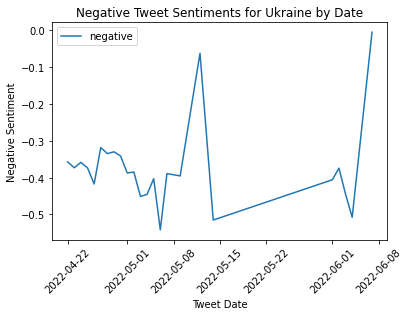

In [94]:
# Visualize tweet negative sentiment for Ukraine by date
# get dates in the dataframe 
dates = negative_for_ukraine["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean negative score for each date
negative_ukraine_by_date =  negative_for_ukraine.groupby([negative_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_ukraine_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [95]:
# Extract positive score of twits and time, when they were created
positive_for_ukraine = ukraine_df[['tweetcreatedts', 'positive']]
positive_for_ukraine.head(5)

,tweetcreatedts,positive
0,2022-04-22,0.270449
2,2022-04-24,0.098457
6,2022-04-29,0.630523
14,2022-04-29,0.007898
22,2022-04-29,0.925082


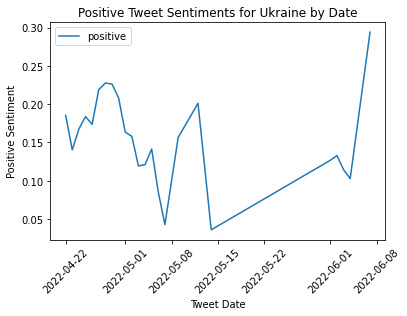

In [96]:
# Visualize tweet positive sentiment for Ukraine by date
# get dates in the dataframe 
dates = positive_for_ukraine["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean positive score for each date
positive_ukraine_by_date =  positive_for_ukraine.groupby([positive_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_ukraine_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [97]:
# Analysis for Russia word
russia_df = tweets_df[tweets_df['cleaned_text'].str.contains('russia')]
russia_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457,94500.0,0.000475
7,ScottLucas_EA,5906,11359,147336,2008-11-07,2022-04-29,0,"[{''text'': ''Russia'', ''indices'': [28, 35]}...",en,1,2022-04-29,False,True,17,uk military intelligence on offensive in in ea...,-0.954947,0.042540,0.002513,165000.0,0.000829
23,avivajazz,4990,4142,175683,2008-07-21,2022-04-29,197,[],en,0,2022-04-29,True,False,17,north kharkiv map april 30 pm ukrainian force...,-0.341673,0.615651,0.042676,165000.0,0.000829
24,minusone,194,166,11503,2008-02-04,2022-04-23,3,"[{''text'': ''Kherson'', ''indices'': [54, 62]}]",en,0,2022-04-23,True,True,16,russians are stealing food from occupied,-0.035933,0.927809,0.036259,148000.0,0.000744
28,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,23,"[{''text'': ''Kyiv'', ''indices'': [58, 63]}, ...",en,0,2022-04-29,True,False,17,kyiv russian strikes slammed into central on t...,-0.001889,0.035071,0.963041,165000.0,0.000829


In [98]:
# Extract negative score for Russia of twits and time, when they were created
negative_for_russia = russia_df[['tweetcreatedts', 'negative']]
negative_for_russia.head(5)

,tweetcreatedts,negative
2,2022-04-24,-0.018234
7,2022-04-29,-0.954947
23,2022-04-29,-0.341673
24,2022-04-23,-0.035933
28,2022-04-29,-0.001889


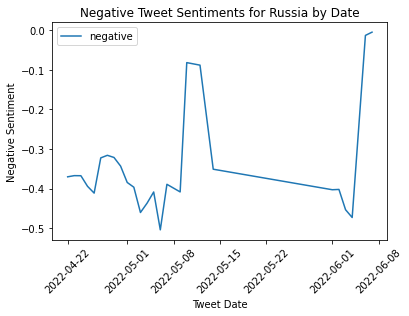

In [99]:
# Visualize negative tweet sentiment for Rossia by date
# get dates in the dataframe 
dates = negative_for_russia["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_russia_by_date =  negative_for_russia.groupby([negative_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_russia_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Russia by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [100]:
# Extract positive score of twits for Russia and time, when they were created
positive_for_russia = russia_df[['tweetcreatedts', 'positive']]
positive_for_russia.head(5)

,tweetcreatedts,positive
2,2022-04-24,0.098457
7,2022-04-29,0.002513
23,2022-04-29,0.042676
24,2022-04-23,0.036259
28,2022-04-29,0.963041


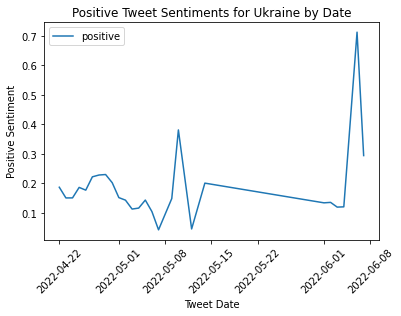

In [101]:
# Visualize tweet positive sentiment for Russia by date
# get dates in the dataframe 
dates = positive_for_russia["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average positive score for each date
positive_russia_by_date =  positive_for_russia.groupby([positive_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_russia_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

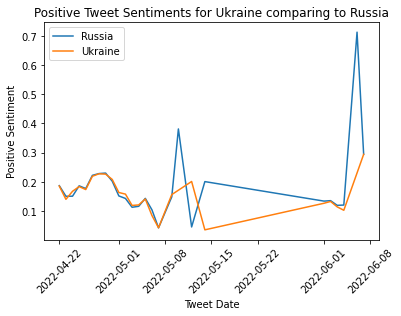

In [102]:
# The plot for Ukraine and Russia positive together
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_russia_by_date['positive'], label ='Russia')
ax.plot(positive_ukraine_by_date['positive'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()


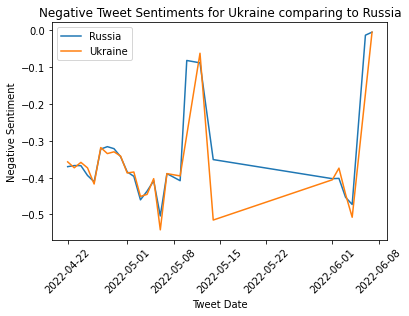

In [103]:
# The plot for Ukraine and Russia negative together
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_russia_by_date['negative'], label ='Russia')
ax.plot(negative_ukraine_by_date['negative'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()

# Analysis for Zelensky - Putin comparison

In [104]:
# Analysis for Zelensky word
zelensky_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
zelensky_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449,196000.0,0.000985
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457,94500.0,0.000475
6,berrysname,2831,2161,220797,2008-09-07,2022-04-29,465,[],en,0,2022-04-29,True,False,17,the house passed legislation to10 to allow pre...,-0.046402,0.323075,0.630523,165000.0,0.000829
14,greenpost,4855,4844,105613,2008-04-23,2022-04-29,78,"[{''text'': ''satellite'', ''indices'': [22, 3...",en,0,2022-04-29,True,False,17,our latest imagery from this morning march 1...,-0.782127,0.209975,0.007898,165000.0,0.000829
22,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,24,"[{''text'': ''Ukraine'', ''indices'': [15, 23]}]",en,0,2022-04-29,True,False,17,is today a slaughterhouse right in the heart o...,-0.003421,0.071497,0.925082,165000.0,0.000829


In [105]:
# Extract negative score for Zelensky of twits and time, when they were created
negative_for_zelensky = zelensky_df[['tweetcreatedts', 'negative']]
negative_for_zelensky.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
2,2022-04-24,-0.018234
6,2022-04-29,-0.046402
14,2022-04-29,-0.782127
22,2022-04-29,-0.003421


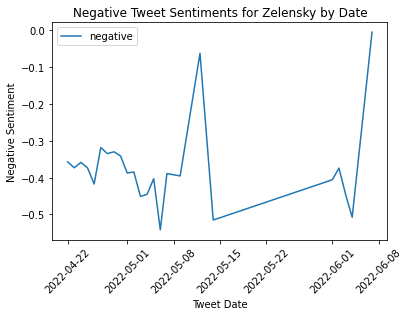

In [106]:
# Visualize negative tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = negative_for_zelensky["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_zelensky_by_date =  negative_for_zelensky.groupby([negative_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_zelensky_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [107]:
# Extract positive score for Zelensky of twits and time, when they were created
positive_for_zelensky = zelensky_df[['tweetcreatedts', 'positive']]
positive_for_zelensky.head(5)

,tweetcreatedts,positive
0,2022-04-22,0.270449
2,2022-04-24,0.098457
6,2022-04-29,0.630523
14,2022-04-29,0.007898
22,2022-04-29,0.925082


In [108]:
# Visualize positive tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = positive_for_zelensky["tweetcreatedts"].dt.positive_by_date
# group tweet timestamps by date and get average negative score for each date
positive_zelensky_by_date =  positive_for_zelensky.groupby([positive_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_zelensky_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

AttributeError: ignored

In [ ]:
# Analysis for Putin word
putin_df = tweets_df[tweets_df['cleaned_text'].str.contains('putin')]
putin_df.head(5)

In [ ]:
# Extract negative score for Putin of twits and time, when they were created
negative_for_putin = putin_df[['tweetcreatedts', 'negative']]
negative_for_putin.head(5)

In [ ]:
# Visualize negative tweet sentiment for Putin by date
# get dates in the dataframe 
dates = negative_for_putin["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_putin_by_date =  negative_for_putin.groupby([negative_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_putin_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Extract positive score for Putin of twits and time, when they were created
positive_for_putin = putin_df[['tweetcreatedts', 'positive']]
positive_for_putin.head(5)

In [ ]:
# Visualize positive tweet sentiment for Putin by date
# get dates in the dataframe 
dates = positive_for_putin["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
positive_putin_by_date =  positive_for_putin.groupby([positive_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_putin_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# The plot comparing positive score for Zelensky and Putin
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_zelensky_by_date['positive'], label='Zelensky')
ax.plot(positive_putin_by_date['positive'], label='Putin')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# The plot comparing negative score for Zelensky and Putin
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_zelensky_by_date['negative'], label='Zelensky')
ax.plot(negative_putin_by_date['negative'], label='Putin')
plt.legend(loc="upper left")
plt.show()

**Get our transformed raw data into our database**

In [ ]:
# Convert Pandas dataframe to Spark
tweets_df = spark.createDataFrame(tweets_df) 
tweets_df.printSchema()
tweets_df.show()

In [ ]:
# Store environmental variable
from getpass import getpass
password = getpass('password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://tweets.cnzbbvrrhst7.us-west-1.rds.amazonaws.com:5432/postgres"
config = {"user":"uatweets",
          "password": password,
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to active_user table in RDS
tweets_df.write.jdbc(url=jdbc_url, table='twitter_sentiments.csv', mode=mode, properties=config)

In [ ]:
# Saving the data
file_path = "/Users/olgapodolska/Desktop/UA_War_my/resources/twitter_sentiments.csv"
tweets_df.to_csv(file_path, index=False)